In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [2]:
counts = pd.read_csv('../data/non_denoised/csv_tables/counts.csv', engine="pyarrow", index_col='cell_id')
exprs = pd.read_csv('../data/non_denoised/csv_tables/exprs.csv', engine="pyarrow", index_col=0)
metadata = pd.read_csv('../data/non_denoised/csv_tables/metadata.csv', engine="pyarrow", index_col=0)
metadata['patient_n']=metadata['patient_n'].astype('category')
metadata['slide_id']=metadata['slide_id'].astype('category')
marker_data = pd.read_csv('../data/non_denoised/csv_tables/marker_data.csv', engine="pyarrow", index_col=0)
fastMNN= pd.read_csv('../data/non_denoised/csv_tables/fastMNN.csv', engine="pyarrow", index_col=0)
UMAP_mnnCorrected = pd.read_csv('../data/non_denoised/csv_tables/UMAP_mnnCorrected.csv', engine="pyarrow", index_col=0)

ValueError: Index cell_id invalid

In [ ]:
adata = ad.AnnData(counts)
adata.obs_names = counts.index
adata.var_names = counts.columns
adata.obs=metadata
adata.var=marker_data
adata.layers['exprs'] = exprs
adata.obsm['fastMNN'] = fastMNN
adata.obsm['UMAP_mnnCorrected'] = UMAP_mnnCorrected


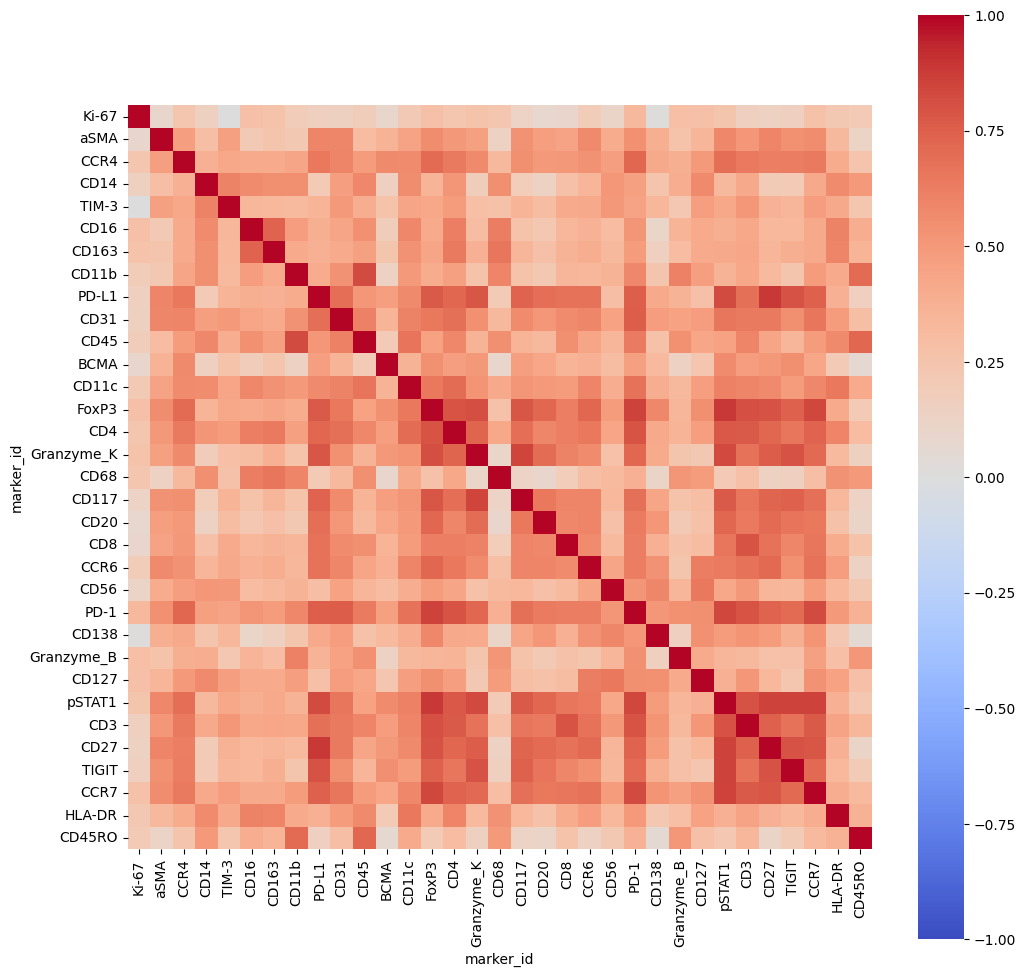

In [4]:
data = pd.DataFrame(adata.layers['exprs'])
data.index=adata.obs_names
data.columns = adata.var_names
data = data.drop(['Histone_H3','ICSK1','ICSK2'],axis=1)
corrplot = data.corr().abs()
corrplot.index=data.columns
corrplot.columns = data.columns

plt.figure(figsize=(12,12))
sns.heatmap(corrplot, vmin=-1, vmax=1,cmap='coolwarm', square=True)
plt.show()

we have a lot of correlation between features, let's see which features correlates most.

In [5]:
# Create a mask for features with high correlation
mask = np.triu(np.ones_like(corrplot, dtype=bool), k=1)

# Identify pairs of features with correlation higher than threshold
threshold = 0.8
high_corr_pairs = [(corrplot.index[i], corrplot.columns[j]) 
                   for i, j in zip(*np.where(corrplot > threshold)) if i!=j]

set_pairs = set()
for i in range(0,len(high_corr_pairs)):
    pair = tuple(set(reversed(high_corr_pairs[i])))
    set_pairs.add(pair)


print(f"Pairs with correlation higher than: {threshold}:\n{list(set_pairs)}")

Pairs with correlation higher than: 0.8:
[('FoxP3', 'Granzyme_K'), ('CCR7', 'FoxP3'), ('FoxP3', 'PD-1'), ('PD-L1', 'CD27'), ('pSTAT1', 'TIGIT'), ('FoxP3', 'pSTAT1'), ('Granzyme_K', 'pSTAT1'), ('pSTAT1', 'PD-1'), ('CD3', 'FoxP3'), ('CCR7', 'PD-1'), ('pSTAT1', 'Granzyme_K'), ('CD27', 'pSTAT1'), ('CD117', 'Granzyme_K'), ('PD-L1', 'pSTAT1'), ('CD45', 'CD11b'), ('CCR7', 'pSTAT1')]


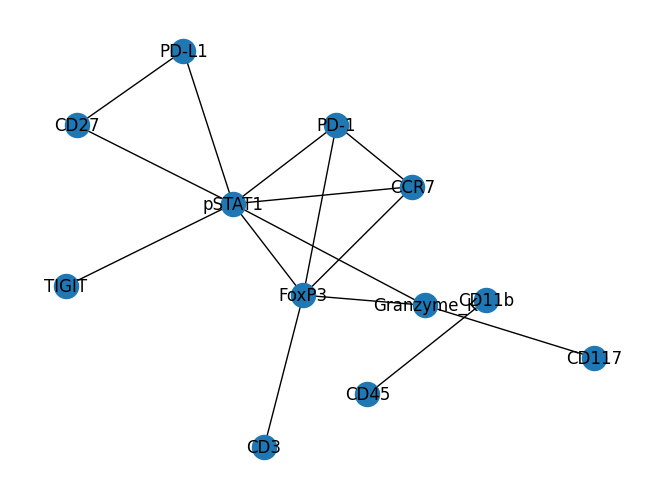

In [6]:
import networkx as nx

G= nx.from_edgelist(set_pairs)
nx.draw_kamada_kawai(G,with_labels=True)

In [7]:
pd.DataFrame.from_dict(dict(G.degree), orient='index').sort_values(by=0, ascending=False)

0
pSTAT1      7
FoxP3       5
Granzyme_K  3
CCR7        3
PD-1        3
PD-L1       2
CD27        2
TIGIT       1
CD3         1
CD117       1
CD45        1
CD11b       1

We have an interesting cluster of features that correlates each others. Now, I am going to remove those nodes with high degree (correlate with several other features) or are not useful for our classification, until we don't have anymore edges:

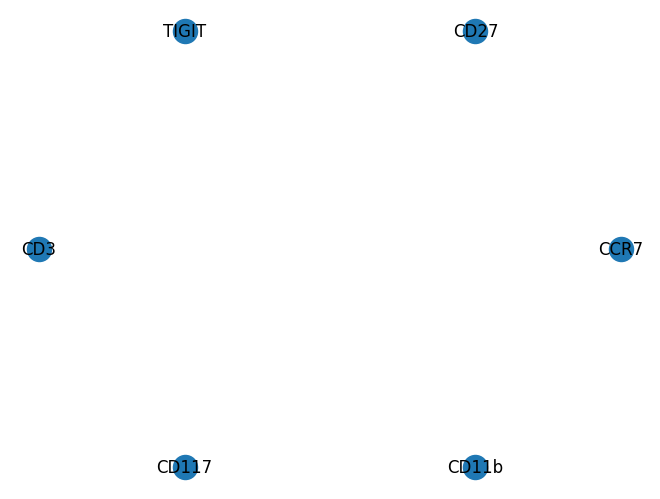

In [8]:
N = G.copy()

nodes_to_remove = ['pSTAT1','Granzyme_K','FoxP3','PD-1','PD-L1','CD45']
N.remove_nodes_from(nodes_to_remove)
nx.draw_circular(N,with_labels=True)

In [9]:
##Testing all features + L2 regularisation

data = data.drop(nodes_to_remove, axis=1)

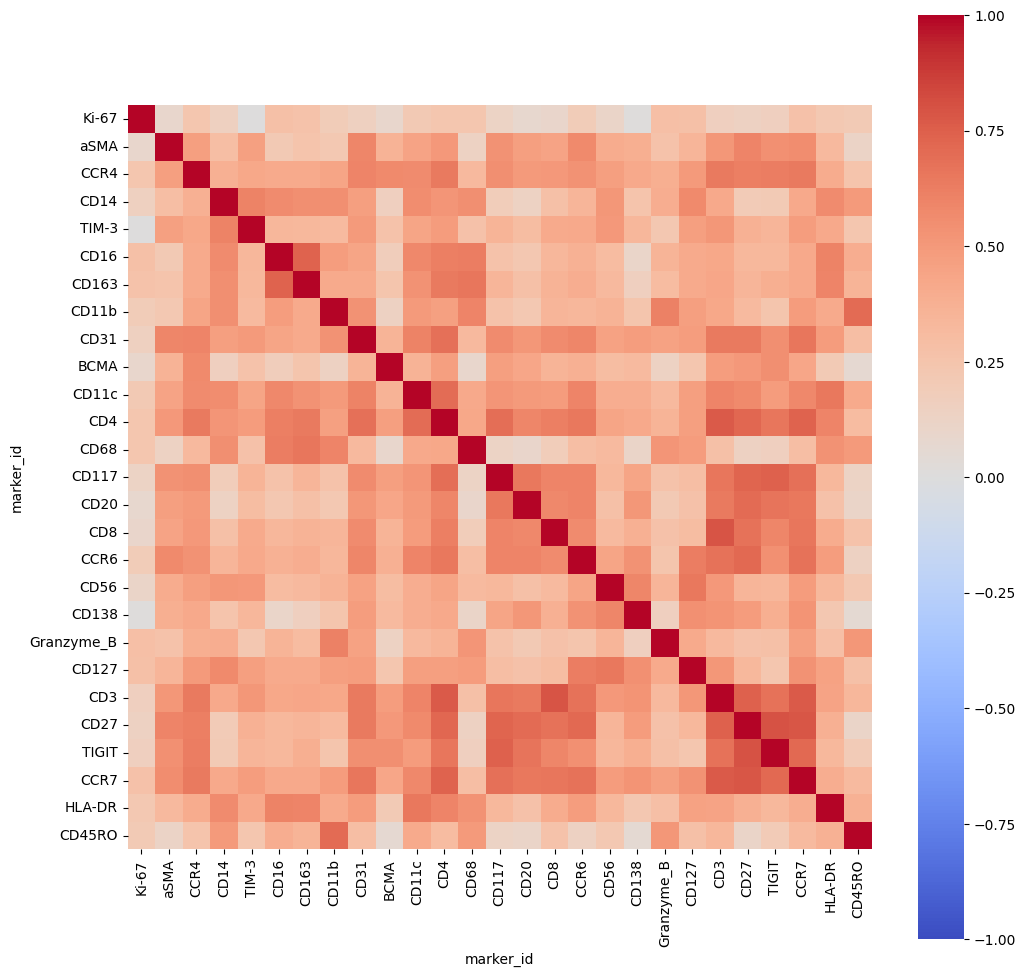

In [10]:
corrplot = data.corr().abs()
# corrplot.index=adata.var_names
# corrplot.columns = adata.var_names

plt.figure(figsize=(12,12))
sns.heatmap(corrplot, vmin=-1, vmax=1,cmap='coolwarm', square=True)
plt.show()

# Classifier

In [11]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LearningCurveDisplay
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.tree import export_graphviz
from IPython.display import Image



features_oi = ["aSMA","CD31",
                 "CD14","CD16",
                 "CD11b","CD11c","CD68","HLA-DR",
                 "CD45","CD45RO",
                 "CD4","CD8","CD3",
                 "CD20","CD138","CD27",
                 "CD56"]

df = data.copy()

# Filter features
#df = df[features_oi]

X = df
y= pd.DataFrame(adata.obs['major_label'])
y.columns = ['label']
print(f"Training set: {X.shape[0]} obs, {X.shape[1]} features\nLabels: {len(y['label'].unique())}")

Training set: 53046 obs, 27 features
Labels: 14


Simplify labels

In [12]:
simplify_labels = {'CD4 T':'T',
                   'CD8 T':'T',
                   'Non-classical Monocytes':'Monocytes',
                   'Classical monocytes':'Monocytes',
                   'MAST':'Other myeloid',
                   'DC':'Other myeloid'}
y['label']=y['label'].replace(simplify_labels)
y['label'].value_counts()

label
Other myeloid     12660
Plasma             7924
Monocytes          7219
T                  6666
Myeloma            5677
Megakaryocytes     5641
B                  2560
Unclassified       1955
Endothelial        1524
NK                 1220
Name: count, dtype: int64

In [13]:
le = LabelEncoder()
le.fit(y['label'])
y['label'] = le.transform(y['label'])
le.classes_

array(['B', 'Endothelial', 'Megakaryocytes', 'Monocytes', 'Myeloma', 'NK',
       'Other myeloid', 'Plasma', 'T', 'Unclassified'], dtype=object)

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
import xgboost as xgb
import time

model = xgb.XGBClassifier(random_state=12345)

model.fit(X_train, y_train['label'])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import cross_val_score, GridSearchCV


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test['label'], y_pred)
precision = precision_score(y_test['label'], y_pred,average='weighted')
recall = recall_score(y_test['label'], y_pred,average='weighted')
mcc = matthews_corrcoef(y_test['label'], y_pred)

# Print the best hyperparameters
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nMCC: {mcc}')#\nTraining time: {round(end-start,2)} seconds')

Accuracy: 0.8479736098020735
Precision: 0.8472971641075326
Recall: 0.8479736098020735
MCC: 0.8229179127827135


## Parameters optimization

### Right number of estimators

Finding the right number of estimators in order to optimize AUC:

In [ ]:
def modelfit(alg, X_train,y_train,X_test,y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, min_delta=1e-3):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train)
        ## Add callback for earlystopping, min_delta 1e-3 to avoid overfitting??
        es = xgb.callback.EarlyStopping(
            rounds=early_stopping_rounds,
            min_delta=min_delta,
            save_best=False)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', callbacks=[es])
        alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)

    #Print model report:
    print("\nModel Report")
    print(f"Train MCC: {round(matthews_corrcoef(y_train, dtrain_predictions),4)}\nTest MCC: {round(matthews_corrcoef(y_test, dtest_predictions),4)}")
    print(f"ROC_AUC Score (Train): {round(roc_auc_score(y_train, dtrain_predprob, multi_class='ovr'),4)}\nROC_AUC Score (Test): {round(roc_auc_score(y_test, dtest_predprob, multi_class='ovr'),4)}")

                   
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return cvresult

In [270]:
# xgb_test = xgb.XGBClassifier(learning_rate =0.1,
#                      n_estimators=10,
#                      max_depth=5,
#                      min_child_weight=1,
#                      gamma=0,
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      objective= 'multi:softmax',
#                      num_class=len(le.classes_),
#                      nthread=24,
#                      seed=12345)
# modelfit(xgb_test, X_train, y_train['label'],X_test, y_test['label'],early_stopping_rounds=10, min_delta=0.1)

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Train MCC: 0.5642
Test MCC: 0.5316
ROC_AUC Score (Train): 0.899
ROC_AUC Score (Test): 0.88


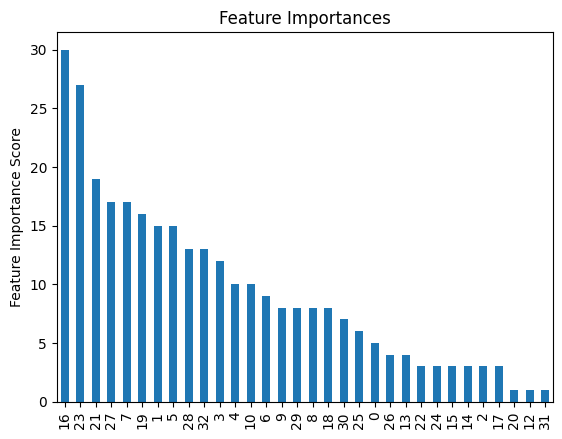

In [292]:
xgb1 = xgb.XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softmax',
                     num_class=len(le.classes_),
                     nthread=24,
                     seed=12345)
n_estimators = modelfit(xgb1, X_train_sc, y_train['label'],X_test_sc, y_test['label'],early_stopping_rounds=0)

In [283]:
xgb1.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('xgb1',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=1, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=24,
                 num_class=10, ...))],
 'verbose': False,
 'scaler': StandardScaler(),
 'xgb1': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsampl

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

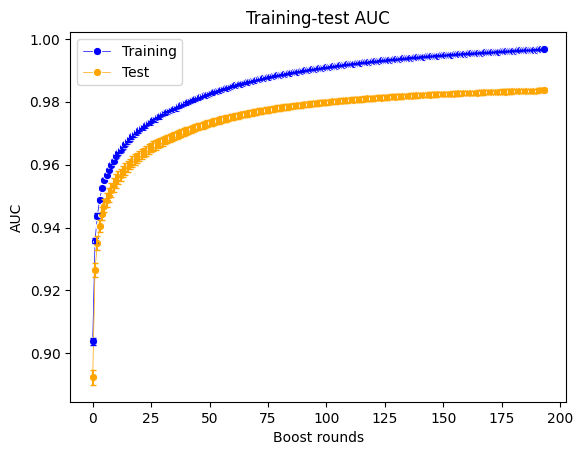

In [272]:
plt.figure()

sns.lineplot(data=n_estimators, 
             x=n_estimators.index, 
             y='train-auc-mean', 
             marker='o', 
             color='blue', 
             lw=.5,
             label='Training')

sns.lineplot(data=n_estimators, 
             x=n_estimators.index, 
             y='test-auc-mean', 
             marker='o', 
             color='orange', 
             lw=.5,
             label='Test')


plt.errorbar(n_estimators.index, 
             n_estimators['train-auc-mean'],
             yerr=n_estimators['train-auc-std'], 
             fmt='none',
             ecolor='blue', 
             capsize=2)

plt.errorbar(n_estimators.index, 
             n_estimators['test-auc-mean'],
             yerr=n_estimators['test-auc-std'], 
             fmt='none',
             ecolor='orange', 
             capsize=2)

# Set labels and title
plt.xlabel('Boost rounds')
plt.ylabel('AUC')
plt.title('Training-test AUC')

# Show legend
plt.legend()

# Show plot
plt.show()

In [274]:
from IPython.display import Markdown

Markdown(f"""

The optimal number of estimators is {n_estimators.shape[0]}
""")



The optimal number of estimators is 194


In [275]:
# xgb_tmp = xgb.XGBClassifier(learning_rate =0.1,
#                      n_estimators=n_estimators.shape[0],
#                      max_depth=5,
#                      min_child_weight=1,
#                      gamma=0,
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      objective= 'multi:softmax',
#                      num_class=len(le.classes_),
#                      nthread=24,
#                      seed=12345)

# model = xgb_tmp.fit(X_train,y_train['label'])

### Optimize tree params

Now I am going to optimize the first two tree parameters. To keep control of the overfitting, I will compare the validation MCC with the one obtained from the previous run.
- max_depth: Depth of the trees, deeper threes may be more accurate but risk to overfit.
- min_child_weight: optimize leaf nodes, with small values, smaller groups can create a leaf node. Low values are good for imbalanced class problems (our)

In [276]:
param_test1 = {
    'max_depth':range(1,10,2),
    'min_child_weight':range(1,6,2)
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch1 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test1, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch1.fit(X_train,y_train['label'])
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=194,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5,
             param_grid={'max_depth': range(1, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='matthews_corrcoef')

In [277]:
print(f"Best score: {round(gsearch1.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch1.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch1.best_params_}")

Best score: 0.8247
Val score: 0.8356
Best parameters: {'max_depth': 9, 'min_child_weight': 1}


Max depth is 9, I am going to explore higher values. Min child weight is 3, not changing the parameter.

In [278]:
param_test2 = {
    'max_depth':range(9,21,2),
    'min_child_weight':range(1,6,2)
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch2 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test2, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch2.fit(X_train,y_train['label'])
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=194,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5,
             param_grid={'max_depth': range(9, 21, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='matthews_corrcoef')

In [279]:
print(f"Best score: {round(gsearch2.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch2.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch2.best_params_}")

Best score: 0.8275
Val score: 0.836
Best parameters: {'max_depth': 15, 'min_child_weight': 5}


In [280]:
param_test3 = {
    'max_depth':[8,9,10],
    'min_child_weight':[2,3,4]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch3 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test3, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch3.fit(X_train,y_train['label'])
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=194,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5,
             param_grid={'max_depth': [8, 9, 10],
                         'min_child_weight': [2, 3, 4]},
             scoring='matthews_corrcoef')

In [52]:
print(f"Best score: {round(gsearch3.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch3.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch3.best_params_}")

Best score: 0.8273
Val score: 0.8322
Best parameters: {'max_depth': 9, 'min_child_weight': 3}


In [60]:
Markdown(f"""
Best tree parameters are:
- max_depth: 9
- min_child_weight: 3


now I a mgoing to optimize:
- gamma: minimum loss reduction to create further partitions. Lower split loss could allow non-favourable splits that are followed by highly favourable splits.


I am going to test a first wide set of gammas:
{[i/10.0 for i in range(0,12,2)]}

Then I will reduce the contour.
""")


Best tree parameters are:
- max_depth: 9
- min_child_weight: 3


now I a mgoing to optimize:
- gamma: minimum loss reduction to create further partitions. Lower split loss could allow non-favourable splits that are followed by highly favourable splits.


I am going to test a first wide set of gammas:
[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

Then I will reduce the contour.


In [63]:
[i/100 for i in range(0,12,2)]

[0.0, 0.02, 0.04, 0.06, 0.08, 0.1]

In [64]:

param_test4 = {
    'gamma':[i/10.0 for i in range(0,12,2)]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=207,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5, param_grid={'gamma': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]},
             scoring='matthews_corrcoef')

In [65]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8273
Val score: 0.8322
Best parameters: {'gamma': 0.0}


In [ ]:
param_test4 = {
    'gamma':[i/100 for i in range(0,12,2)]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

In [66]:
Markdown(f"""
Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0

Update number of boosting rounds
""")


Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0

Update number of boosting rounds


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Train MCC: 0.9935
Test MCC: 0.8266
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.989


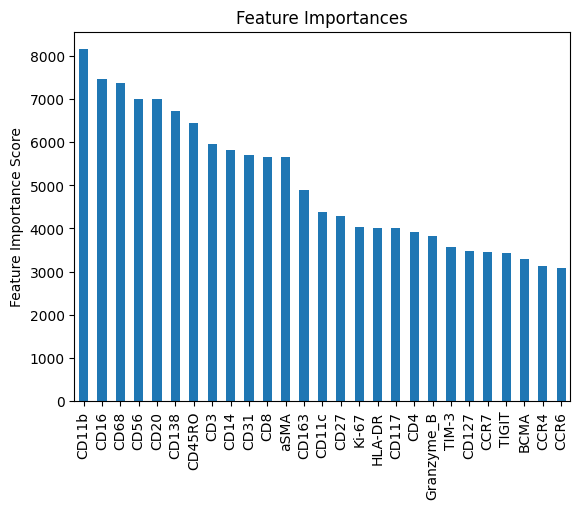

In [71]:
gamma=0.0

xgb2 = xgb.XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=max_depth,
                     min_child_weight=min_child_weight,
                     gamma=gamma,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softmax',
                     num_class=len(le.classes_),
                     nthread=24,
                     seed=12345)
n_estimators = modelfit(xgb2, X_train, y_train['label'],X_test, y_test['label'],early_stopping_rounds=50)

We got some improvements! :)

In [80]:
Markdown(f"""

Optimal estimators: {n_estimators.shape[0]}
### subsample colsample_bytree

Now I am going to oprimize:
- subsample: subsample, similar to dropout, it will prevent overfitting
- colsample_bytree: subsample columns (features) for constructing a tree, similarly, is used to reduce overfitting

For both of them I test wide ranges with extreme cses:
- 0.4 Less than half trees/features
- 1 all trees/features

{[i/10.0 for i in range(4,11,2)]}
""")



Optimal estimators: 122
### subsample colsample_bytree

Now I am going to oprimize:
- subsample: subsample, similar to dropout, it will prevent overfitting
- colsample_bytree: subsample columns (features) for constructing a tree, similarly, is used to reduce overfitting

For both of them I test wide ranges with extreme cses:
- 0.4 Less than half trees/features
- 1 all trees/features

[0.4, 0.6, 0.8, 1.0]


In [81]:
param_test4 = {
    'subsample':[i/10.0 for i in range(4,11,2)],
    'colsample_bytree':[i/10.0 for i in range(4,11,2)]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            gamma=gamma,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=122,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
                         'subsample': [0.4, 0.6, 0.8, 1.0]},
             scoring='matthews_corrcoef')

In [82]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8218
Val score: 0.8298
Best parameters: {'colsample_bytree': 1.0, 'subsample': 0.8}


In [95]:
param_test4 = {
    'subsample':[i/100 for i in range(70,100,5)],
    'colsample_bytree':[i/10.0 for i in range(8,11,1)]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            gamma=gamma,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=122,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]},
             scoring='matthews_corrcoef')

In [96]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8224
Val score: 0.8306
Best parameters: {'colsample_bytree': 1.0, 'subsample': 0.85}


In [97]:
Markdown(f"""
Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85


## Regularization parameters

Now I am going to tune L1 regularization, considering the droput of features is set to 0, maybe is not needed but a try is always welcome
- reg_alpha:L1 regularization term on weights. Increasing this value will make model more conservative


testing with:
{[1e-5, 1e-2, 0.1, 1, 100]}
""")


Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85


## Regularization parameters

Now I am going to tune L1 regularization, considering the droput of features is set to 0, maybe is not needed but a try is always welcome
- reg_alpha:L1 regularization term on weights. Increasing this value will make model more conservative


testing with:
[1e-05, 0.01, 0.1, 1, 100]


In [103]:
colsample_bytree=1
subsample=.85



param_test4 = {
 'reg_lambda':[0,1e-5, 1e-2, 0.1, 1, 100]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            gamma=gamma,
                            colsample_bytree=colsample_bytree,
                            subsample=subsample,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=122,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5, param_grid={'reg_lambda': [0, 1e-05, 0.01, 0.1, 1, 100]},
             scoring='matthews_corrcoef')

In [104]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8224
Val score: 0.8306
Best parameters: {'reg_lambda': 1}


In [105]:
param_test4 = {
 'reg_lambda':[0.1, 0.5, 1, 1.5, 2]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            gamma=gamma,
                            colsample_bytree=colsample_bytree,
                            subsample=subsample,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=122,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5, param_grid={'reg_lambda': [0.1, 0.5, 1, 1.5, 2]},
             scoring='matthews_corrcoef')

In [106]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8224
Val score: 0.8306
Best parameters: {'reg_lambda': 1}


In [107]:
reg_lambda=1

param_test4 = {
 'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100]
}

xgb_tmp = xgb.XGBClassifier(learning_rate =0.1, 
                            n_estimators=n_estimators.shape[0], 
                            min_child_weight=min_child_weight,
                            max_depth=max_depth,
                            gamma=gamma,
                            colsample_bytree=colsample_bytree,
                            subsample=subsample,
                            reg_lambda=reg_lambda,
                            objective= 'multi:softmax',
                            num_class=len(le.classes_),
                            nthread=6,
                            seed=12345)


gsearch4 = GridSearchCV(estimator=xgb_tmp,
                        param_grid = param_test4, 
                        scoring='matthews_corrcoef',
                        n_jobs=5,
                        cv=5)



gsearch4.fit(X_train,y_train['label'])


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=122,
                                     n_jobs=None, nthread=6, num_class=10, ...),
             n_jobs=5, param_grid={'reg_alpha': [0, 1e-05, 0.01, 0.1, 1, 100]},
             scoring='matthews_corrcoef')

In [108]:
print(f"Best score: {round(gsearch4.best_score_,4)}\nVal score: {round(matthews_corrcoef(gsearch4.predict(X_test), y_test['label']),4)}\nBest parameters: {gsearch4.best_params_}")

Best score: 0.8226
Val score: 0.8268
Best parameters: {'reg_alpha': 0.01}


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Train MCC: 0.9946
Test MCC: 0.8306
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9891


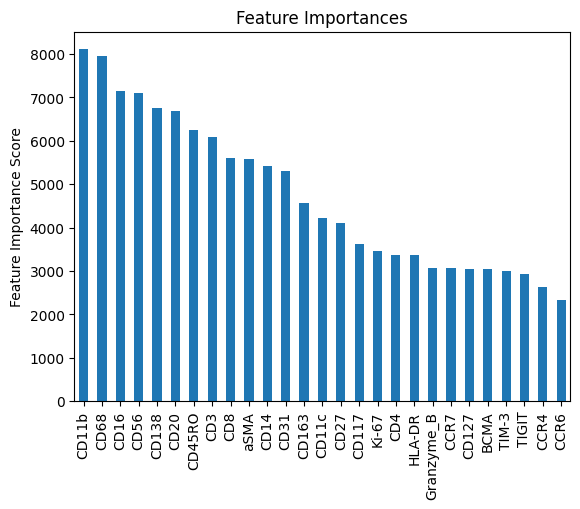

In [115]:
reg_alpha=0.01

xgb3 = xgb.XGBClassifier(learning_rate =0.1,
                        n_estimators=n_estimators.shape[0], 
                        min_child_weight=min_child_weight,
                        max_depth=max_depth,
                        gamma=gamma,
                        colsample_bytree=colsample_bytree,
                        subsample=subsample,
                        reg_lambda=reg_lambda,
                        objective= 'multi:softmax',
                        num_class=len(le.classes_),
                        nthread=24,
                        seed=12345)
n_estimators = modelfit(xgb3, X_train, y_train['label'],X_test, y_test['label'],early_stopping_rounds=50)

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Train MCC: 0.9941
Test MCC: 0.8268
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9891


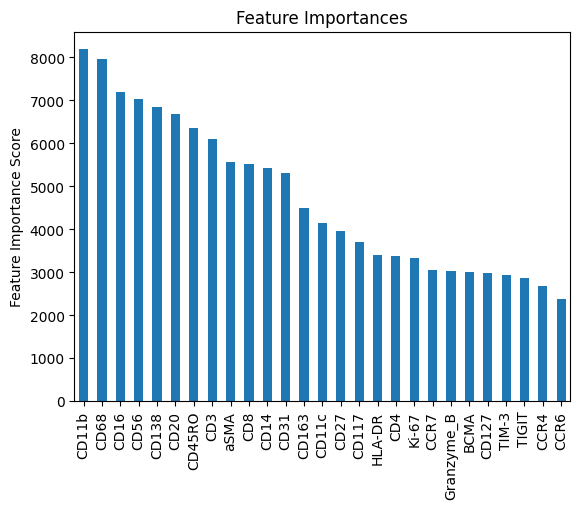

In [116]:
xgb4 = xgb.XGBClassifier(learning_rate =0.1,
                        n_estimators=n_estimators.shape[0], 
                        min_child_weight=min_child_weight,
                        max_depth=max_depth,
                        gamma=gamma,
                        colsample_bytree=colsample_bytree,
                        subsample=subsample,
                        reg_lambda=reg_lambda,
                        reg_alpha=reg_alpha,
                        objective= 'multi:softmax',
                        num_class=len(le.classes_),
                        nthread=24,
                        seed=12345)
n_estimators_alpha = modelfit(xgb4, X_train, y_train['label'],X_test, y_test['label'],early_stopping_rounds=50)

In [128]:
Markdown(f"""
Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85
- reg_lambda=1
- reg_alpha=0 (default)
- n_estimators: {n_estimators.shape[0]}


## Tune learning rate


Next step, I will play on reducing learning rate and increasing trees to ptimize accuracy vs overfitting.
Now I will:
- divide learning rate and multiply n_estimators by N
- tune N until optimal accuracy without reducing val accuracy


Reference:
```
Model Report
Train MCC: 0.9946
Test MCC: 0.8306
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9891
```
""")


Best tree parameters are:
- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85
- reg_lambda=1
- reg_alpha=0 (default)
- n_estimators: 362


## Tune learning rate


Next step, I will play on reducing learning rate and increasing trees to ptimize accuracy vs overfitting.
Now I will:
- divide learning rate and multiply n_estimators by N
- tune N until optimal accuracy without reducing val accuracy


Reference:
```
Model Report
Train MCC: 0.9946
Test MCC: 0.8306
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9891
```


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Train MCC: 0.9961
Test MCC: 0.8317
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9892


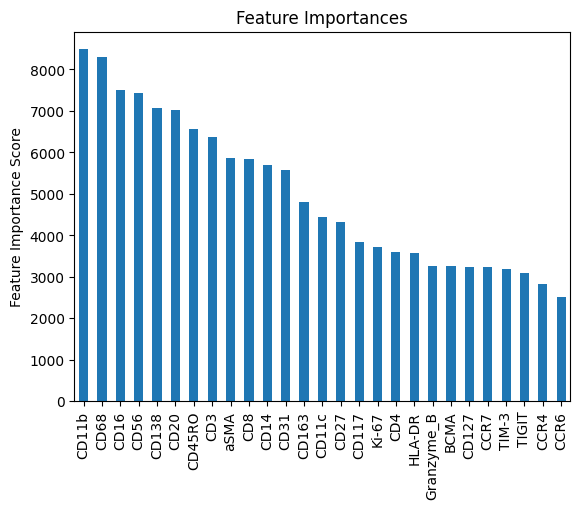

In [142]:
learning_rate=.1
n_estimators=1000
N=1

xgb5 = xgb.XGBClassifier(learning_rate =learning_rate/N,
                        n_estimators=n_estimators*N, 
                        min_child_weight=min_child_weight,
                        max_depth=max_depth,
                        gamma=gamma,
                        colsample_bytree=colsample_bytree,
                        subsample=subsample,
                        reg_lambda=reg_lambda,
                        objective= 'multi:softmax',
                        num_class=len(le.classes_),
                        nthread=24,
                        seed=12345)
n_estimators = modelfit(xgb5, X_train, y_train['label'],X_test, y_test['label'],early_stopping_rounds=50)

In [143]:
Markdown(f"""

## Final set of parameters:

- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85
- reg_lambda=1
- reg_alpha=0 (default)
- n_estimators: {n_estimators.shape[0]}
- learning_rate: 0.1


```
Model Report
Train MCC: 0.9961
Test MCC: 0.8317
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9892
```



# Fit, metrics:

Fitting the model and plotting some metrics:


""")



## Final set of parameters:

- max_depth: 9
- min_child_weight: 3
- gamma: 0.0
- colsample_bytree: 1.0
- subsample: 0.85
- reg_lambda=1
- reg_alpha=0 (default)
- n_estimators: 132
- learning_rate: 0.1


```
Model Report
Train MCC: 0.9961
Test MCC: 0.8317
ROC_AUC Score (Train): 1.0
ROC_AUC Score (Test): 0.9892
```



# Fit, metrics:

Fitting the model and prlotting some metrics:




In [144]:
learning_rate=.1
n_estimators=n_estimators.shape[0]
N=1

xgb_classifier = xgb.XGBClassifier(learning_rate =learning_rate/N,
                                    n_estimators=n_estimators*N, 
                                    min_child_weight=min_child_weight,
                                    max_depth=max_depth,
                                    gamma=gamma,
                                    colsample_bytree=colsample_bytree,
                                    subsample=subsample,
                                    reg_lambda=reg_lambda,
                                    objective= 'multi:softmax',
                                    num_class=len(le.classes_),
                                    nthread=24,
                                    seed=12345)
model=xgb_classifier.fit(X_train, y_train['label'])

In [145]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=132,
              n_jobs=None, nthread=24, num_class=10, ...)

In [147]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import cross_val_score, GridSearchCV


y_pred = model.predict(X_test)
y_pred_train =  model.predict(X_train)

## Train metrics:
train_accuracy = accuracy_score(y_train['label'], y_pred_train)
train_precision = precision_score(y_train['label'], y_pred_train,average='weighted')
train_recall = recall_score(y_train['label'], y_pred_train,average='weighted')
train_mcc = matthews_corrcoef(y_train['label'], y_pred_train)

## Test metrics:
test_accuracy = accuracy_score(y_test['label'], y_pred)
test_precision = precision_score(y_test['label'], y_pred,average='weighted')
test_recall = recall_score(y_test['label'], y_pred,average='weighted')
test_mcc = matthews_corrcoef(y_test['label'], y_pred)


train_test_metrics = pd.DataFrame({
    'Train':[train_accuracy,train_precision,train_recall,train_mcc],
    'Test':[test_accuracy,test_precision,test_recall,test_mcc]},
                                index=['Accuracy','Precision','Recall','MCC'])
# Print the best hyperparameters
train_test_metrics

Train      Test
Accuracy   0.996630  0.855325
Precision  0.996636  0.854639
Recall     0.996630  0.855325
MCC        0.996074  0.831675

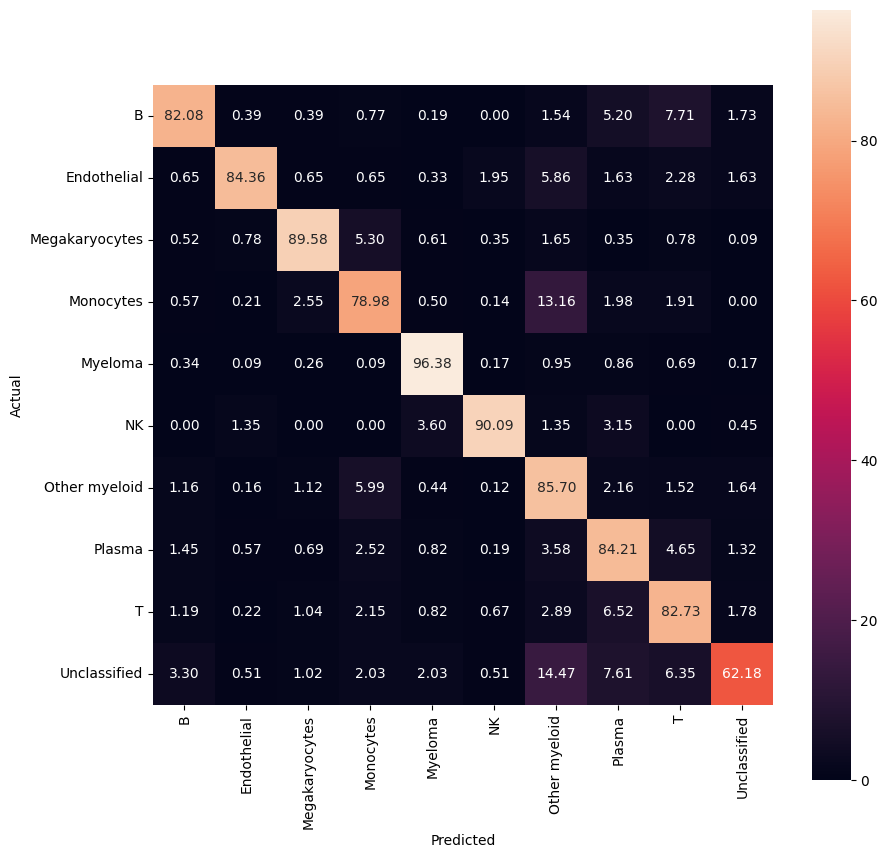

In [25]:
cm = pd.DataFrame(confusion_matrix(y_test['label'], y_pred))
cm.columns = le.inverse_transform(cm.index)
cm.index = le.inverse_transform(cm.index)
cm=cm.div(cm.sum(axis=1), axis=0)*100
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True, fmt=".2f", square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [149]:
# Perform cross-validation to get a more robust estimate of performance
cv_scores = cross_val_score(model, X_train, y_train['label'], cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.84648916 0.85212678 0.85283375 0.85365854 0.84152233]
Average cross-validation score: 0.8493261107773966


The model isn't perfect, some classes are hard to distinguish, especially:
- Monocytes, Other Myeloid
- Other Myeloid, Unclassified

These class will need manual curation later

## Predict and visualize:

Load all the cells, create anndata object, select features and prepare query dataset

In [18]:
counts = pd.read_csv('../data/non_denoised/csv_tables_all_cells/counts.csv', engine="pyarrow", index_col='cell_id')
exprs = pd.read_csv('../data/non_denoised/csv_tables_all_cells/exprs.csv', engine="pyarrow", index_col=0)
metadata = pd.read_csv('../data/non_denoised/csv_tables_all_cells/metadata.csv', engine="pyarrow", index_col=0)
metadata['patient_n']=metadata['patient_n'].astype('category')
metadata['slide_id']=metadata['slide_id'].astype('category')
marker_data = pd.read_csv('../data/non_denoised/csv_tables_all_cells/marker_data.csv', engine="pyarrow", index_col=0)
fastMNN= pd.read_csv('../data/non_denoised/csv_tables_all_cells/fastMNN.csv', engine="pyarrow", index_col=0)
UMAP_mnnCorrected = pd.read_csv('../data/non_denoised/csv_tables_all_cells/UMAP_mnnCorrected.csv', engine="pyarrow", index_col=0)

In [19]:
adata_full = ad.AnnData(counts)
adata_full.obs_names = counts.index
adata_full.var_names = counts.columns
adata_full.obs=metadata
adata_full.var=marker_data
adata_full.layers['exprs'] = exprs
adata_full.obsm['fastMNN'] = fastMNN
adata_full.obsm['UMAP_mnnCorrected'] = UMAP_mnnCorrected


In [20]:
data_full = pd.DataFrame(adata_full.layers['exprs'])
data_full.index=adata_full.obs_names
data_full.columns = adata_full.var_names
data_full=data_full[data.columns]
data_full.shape[0]

530420

### Predict

In [21]:
classes = model.predict(data_full)
cell_labels = pd.DataFrame(le.inverse_transform(classes))
cell_labels.index = data_full.index
cell_labels.columns = ['major_celltype']

In [22]:
props = pd.DataFrame(cell_labels.value_counts())
props = props.reset_index()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


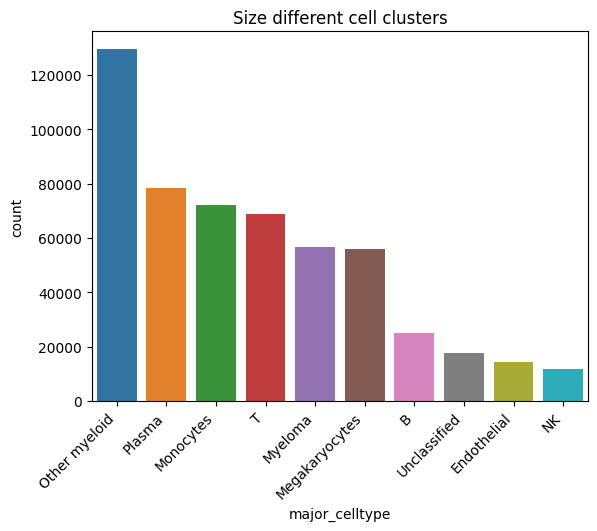

In [23]:
plt.figure()
sns.barplot(data=props, x=props['major_celltype'], y=props['count'])
plt.xticks(rotation=45, ha='right')
plt.title('Size different cell clusters')
plt.show()

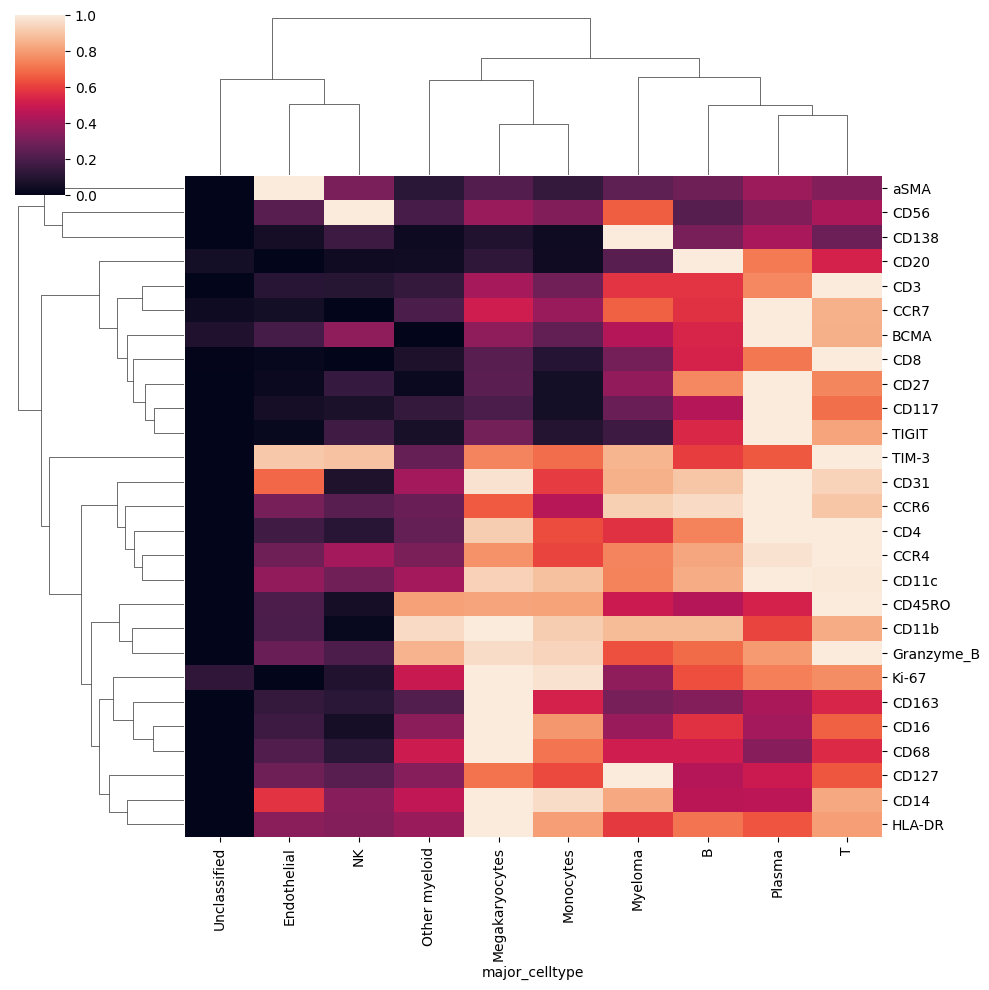

In [24]:
sns.clustermap(pd.concat([data_full,cell_labels],axis=1).groupby(by='major_celltype').mean().T, standard_scale=0)

In [246]:
cell_labels.to_csv('../data/non_denoised/csv_tables_all_cells/major_labels.csv')

In [247]:
! mkdir ../data/non_denoised/models

mkdir: cannot create directory ‘../data/non_denoised/models’: File exists


In [250]:
import pickle

with open('../data/non_denoised/models/XGB_classifier.pkl','wb') as file:
    pickle.dump(model, file)

with open('../data/non_denoised/models/XGB_classifier_label-encoder.pkl','wb') as file:
    pickle.dump(le, file)